In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import matplotlib.image as mpimg

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'

dog_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog1.jpg'
my_pic1_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_pic1.jpg'
my_pic2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_pic2.jpg'

dog = cv2.imread(dog_path)
my_pic1 = cv2.imread(my_pic1_path)
my_pic2 = cv2.imread(my_pic2_path)

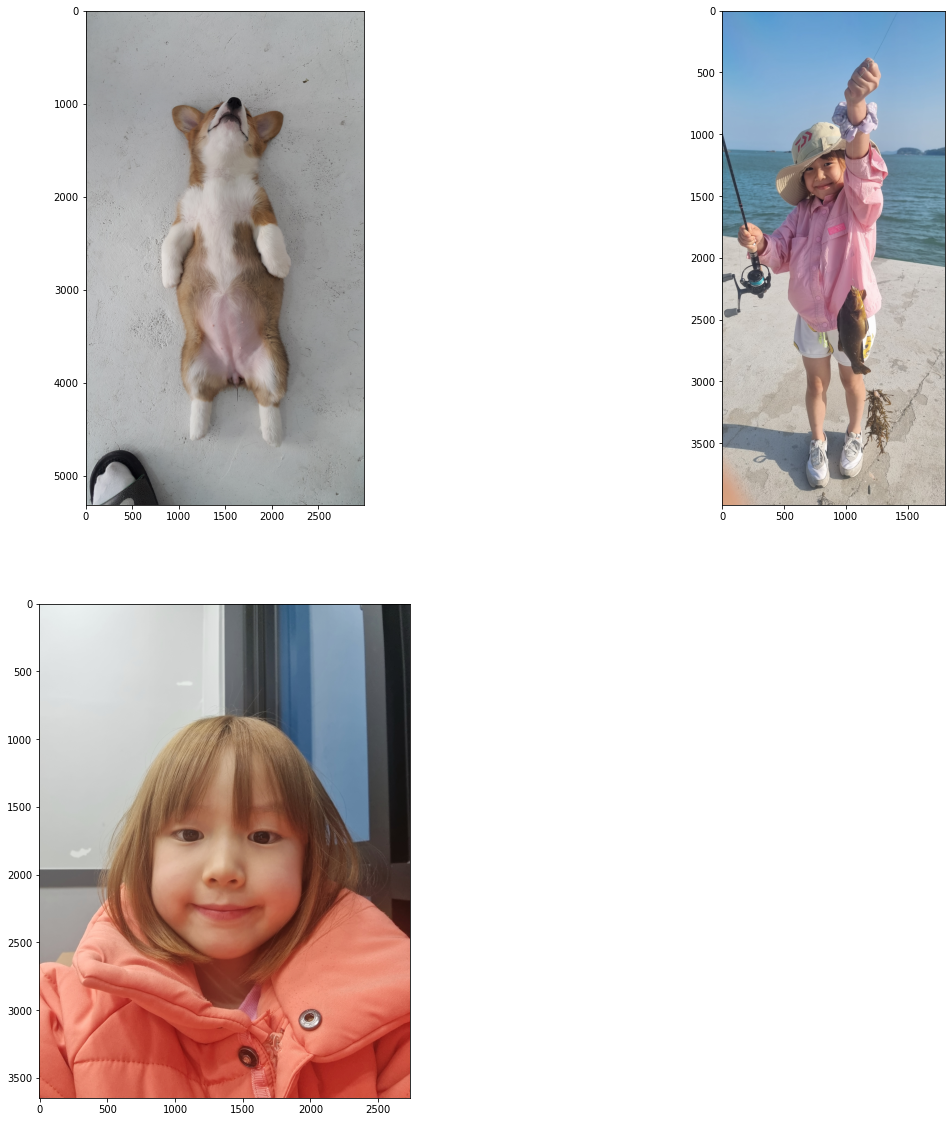

In [3]:
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(cv2.cvtColor(dog, cv2.COLOR_BGR2RGB))

ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(cv2.cvtColor(my_pic1, cv2.COLOR_BGR2RGB))

ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(cv2.cvtColor(my_pic2, cv2.COLOR_BGR2RGB))


plt.show()

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [6]:
# dog
dog_resized, seg_map2 = MODEL.run(dog)
print(dog.shape, dog_resized.shape, seg_map2.max())

(5312, 2988, 3) (513, 288, 3) 12


In [7]:
# my_pic1
my_pic1_resized, seg_map3 = MODEL.run(my_pic1)
print(my_pic1.shape, my_pic1_resized.shape, seg_map3.max())

(4000, 1800, 3) (513, 230, 3) 15


In [8]:
# my_pic2
my_pic2_resized, seg_map4 = MODEL.run(my_pic2)
print(my_pic2.shape, my_pic2_resized.shape, seg_map4.max())

(3648, 2736, 3) (513, 384, 3) 15


In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

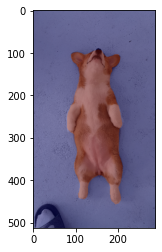

In [10]:
dog_show = dog_resized.copy()
seg_map2 = np.where(seg_map2 == 12, 12, 0)
img_mask2 = seg_map2 * (255/seg_map2.max()) # 255 normalization
img_mask2 = img_mask2.astype(np.uint8)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
dog_show = cv2.addWeighted(dog_show, 0.6, color_mask2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(dog_show, cv2.COLOR_BGR2RGB))
plt.show()

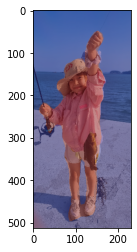

In [11]:
my_pic1_show = my_pic1_resized.copy()
seg_map3 = np.where(seg_map3 == 15, 15, 0)
img_mask3 = seg_map3 * (255/seg_map3.max()) # 255 normalization
img_mask3 = img_mask3.astype(np.uint8)
color_mask3 = cv2.applyColorMap(img_mask3, cv2.COLORMAP_JET)
my_pic1_show = cv2.addWeighted(my_pic1_show, 0.6, color_mask3, 0.35, 0.0)

plt.imshow(cv2.cvtColor(my_pic1_show, cv2.COLOR_BGR2RGB))
plt.show()

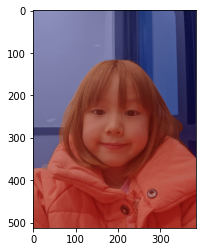

In [12]:
my_pic2_show = my_pic2_resized.copy()
seg_map4 = np.where(seg_map4 == 15, 15, 0)
img_mask4 = seg_map4 * (255/seg_map4.max()) # 255 normalization
img_mask4 = img_mask4.astype(np.uint8)
color_mask4 = cv2.applyColorMap(img_mask4, cv2.COLORMAP_JET)
my_pic2_show = cv2.addWeighted(my_pic2_show, 0.6, color_mask4, 0.35, 0.0)

plt.imshow(cv2.cvtColor(my_pic2_show, cv2.COLOR_BGR2RGB))
plt.show()

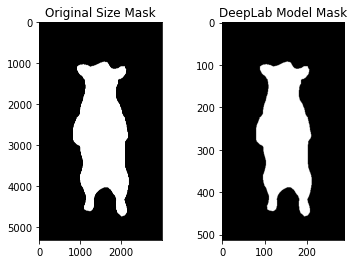

In [13]:
# dog
dog_mask_up = cv2.resize(img_mask2, dog.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, dog_mask_up = cv2.threshold(dog_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(dog_mask_up, cmap=plt.cm.binary_r)
ax.set_title("Original Size Mask")

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask2, cmap=plt.cm.binary_r)
ax.set_title("DeepLab Model Mask")

plt.show()

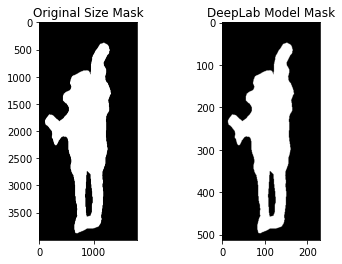

In [14]:
# my_pic1
my_pic1_mask_up = cv2.resize(img_mask3, my_pic1.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, my_pic1_mask_up = cv2.threshold(my_pic1_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(my_pic1_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask3, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

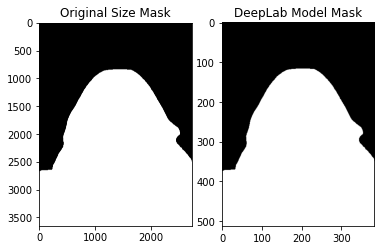

In [15]:
# my_pic2
my_pic2_mask_up = cv2.resize(img_mask4, my_pic2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, my_pic2_mask_up = cv2.threshold(my_pic2_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(my_pic2_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask4, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

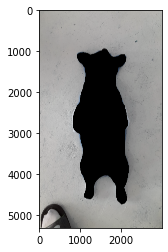

In [16]:
dog_mask_color = cv2.cvtColor(dog_mask_up, cv2.COLOR_GRAY2BGR)
dog_bg_mask = cv2.bitwise_not(dog_mask_color)
dog_bg = cv2.bitwise_and(dog, dog_bg_mask)
plt.imshow(dog_bg)
plt.show()

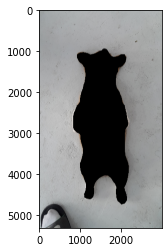

In [17]:
dog_bg_blur = cv2.blur(dog_bg, (20, 20))
plt.imshow(cv2.cvtColor(dog_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

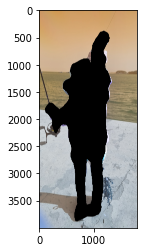

In [18]:
my_pic1_color = cv2.cvtColor(my_pic1_mask_up, cv2.COLOR_GRAY2BGR)
my_pic1_bg_mask = cv2.bitwise_not(my_pic1_color)
my_pic1_bg = cv2.bitwise_and(my_pic1, my_pic1_bg_mask)
plt.imshow(my_pic1_bg)
plt.show()

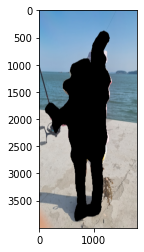

In [19]:
my_pic1_bg_blur = cv2.blur(my_pic1_bg, (15, 15))
plt.imshow(cv2.cvtColor(my_pic1_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

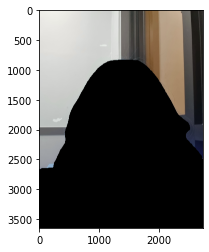

In [20]:
my_pic2_color = cv2.cvtColor(my_pic2_mask_up, cv2.COLOR_GRAY2BGR)
my_pic2_bg_mask = cv2.bitwise_not(my_pic2_color)
my_pic2_bg = cv2.bitwise_and(my_pic2, my_pic2_bg_mask)
plt.imshow(my_pic2_bg)
plt.show()

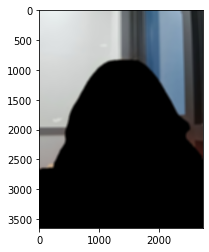

In [21]:
my_pic2_bg_blur = cv2.blur(my_pic2_bg, (50, 50))
plt.imshow(cv2.cvtColor(my_pic2_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

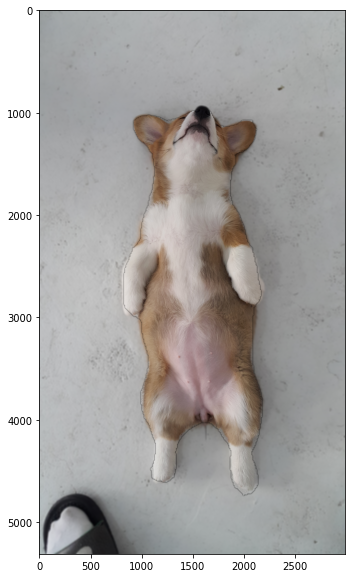

In [22]:
plt.figure(figsize=(20, 10))
dog_concat = np.where(dog_mask_color ==255, dog, dog_bg_blur)
plt.imshow(cv2.cvtColor(dog_concat, cv2.COLOR_BGR2RGB))
plt.show()

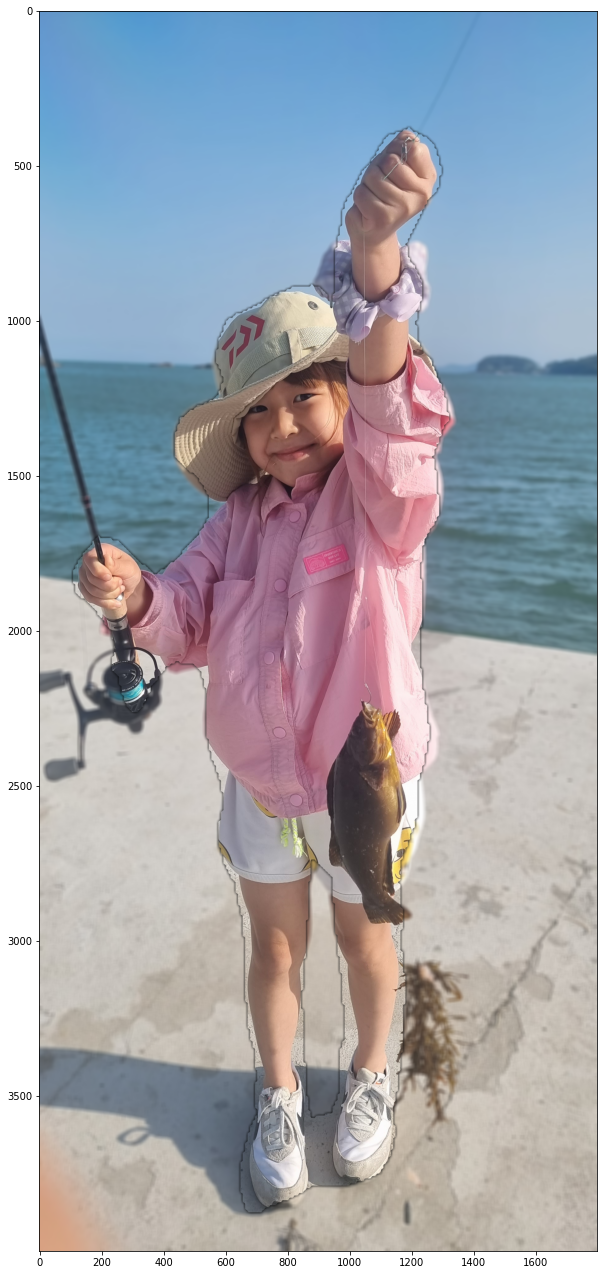

In [23]:
plt.figure(figsize=(10, 30))
my_pic1_concat = np.where(my_pic1_color==255, my_pic1, my_pic1_bg_blur)
plt.imshow(cv2.cvtColor(my_pic1_concat, cv2.COLOR_BGR2RGB))
plt.show()

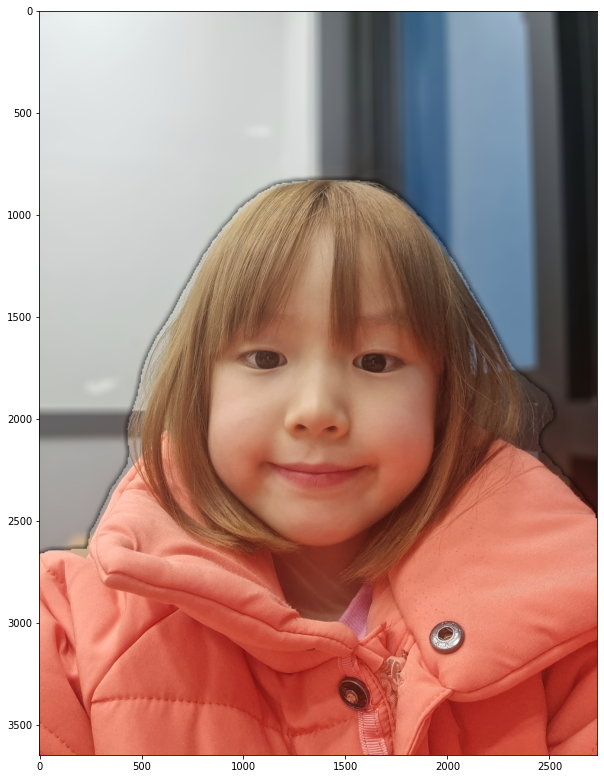

In [24]:
plt.figure(figsize=(10, 30))
my_pic2_concat = np.where(my_pic2_color==255, my_pic2, my_pic2_bg_blur)
plt.imshow(cv2.cvtColor(my_pic2_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

### Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘들다.
### 이미지를 블러처리 하는 과정에서 인물과 배경의 경계 부분도 같이 블러처리 되어버리기 때문에 나중에 이미지를 병합하는 과정에서 배경에 있는 인물 영역이 실제 사진의 인물 영역보다 넓어져 병합 후의 이미지에서 경계 주위로 그림자가 지는 것 같은 현상을 볼 수 있었다. 아무래도 사진 속 인물영역을 정확히 잡는 것이 쉽지 않아 보였다.
### 이런 모델로 이미지변환을 통해 영상제작도 가능할 것으로 보여진다. 실례로 현재 그런 프로그램이 만들어지고 있고 베타서비스 중인 것으로 알고 있다.
### 더 많은 공부를 하여 뒤쳐지지 않는 사람이 되고 싶다. 